# Imports et setup technique

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns

# Chargement des données
## Historiques de vente

In [2]:
path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_V3.csv'
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [3]:
data = pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  )
data.sample(5)

,orgacom,month,week,date,pricetype,client,doctype,origin,salesgroup,material,brutrevenue,brutrevcur,netrevenue,netrevcur,weight,weightunit,margin,margincur,marginperkg
15387398,1ALO,201812,201850,2018-12-13,ZTM,0000215862,ZC10,WEB,F46,000000000000193730,56.89,EUR,56.89,EUR,10.0,KG,3.35,EUR,0.34
20732045,1LRO,201906,201924,2019-06-15,ZTCR,0000185426,ZC10,TV,748,000000000000016985,13.77,EUR,13.77,EUR,2.5,KG,4.48,EUR,1.79
30831340,1SOU,202007,202027,2020-07-02,ZTCE,0000148103,ZC10,TV,801,000000000000030399,5.60,EUR,5.10,EUR,1.2,KG,0.55,EUR,0.46
14453140,1ALO,201811,201845,2018-11-07,ZTCE,0000153728,ZC10,EDI,I09,000000000000090208,36.41,EUR,36.07,EUR,6.0,KG,1.78,EUR,0.30
10330523,1LRO,201806,201825,2018-06-23,ZTCR,0000233820,ZC10,VR,759,000000000000041001,40.45,EUR,40.45,EUR,7.8,KG,18.65,EUR,2.39


## Calcul d'un numéro de commande
On détermine un numéro de commande, afin de regrouper les lignes qui semblent correspondre à une même commande.
La clé de regroupement est :
  - Organisation commerciale
  - Client
  - Date

In [4]:
orders = data.loc[:, ['orgacom', 'client', 'date']].drop_duplicates().reset_index(drop=True)
orders.index.name = 'order_num'

In [5]:
data2 = data.merge(orders.reset_index(), 
                   on=['orgacom', 'client', 'date'])
data2.insert(0, 'order_num', data2.pop('order_num'))

In [6]:
if len(data2) != len(data):
    raise RuntimeError('Something went wrong when computing orders num!')
data = data2
del data2

## Filtres sur les données
### Filtre sur les types de documents
Définition des types de poste valides et invalides.
PAR CONTRE, on ne filtre plus les documents de type avoir !

In [7]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [8]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [9]:
mask = data.doctype.isin(valid_doctypes)
# raw_data = data.copy()
# before_count = len(raw_data)
# data = raw_data.loc[mask]
# after_count = len(data)
# print(f'{before_count - after_count} lines have been delete due to doctype filtering.')
# print(f'{after_count} lines remain.')

## Nettoyage des poids / CA à zéro
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [10]:
if len(data.loc[mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [11]:
if len(data.loc[mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

On supprime les lignes qui ont un poids nul : => NON, on ne le fait pas dans cette nouvelle version !

In [12]:
# mask = mask & (data.weight != 0)
# before_count = len(data)
# data = data.loc[mask]
# after_count = len(data)
# print(f'{before_count - after_count} lines have been delete due to zero weight filtering.')
# print(f'{after_count} lines remain.')

## Calcul des indicateurs manquants

In [13]:
data['purchcost'] = data.brutrevenue - data.margin
data['purchcostperkg'] = data.purchcost / data.weight
data['PMVK'] = data.brutrevenue / data.weight
data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

## Nettoyage des avoirs
### Constat d'erreurs et corrections sur les prix
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

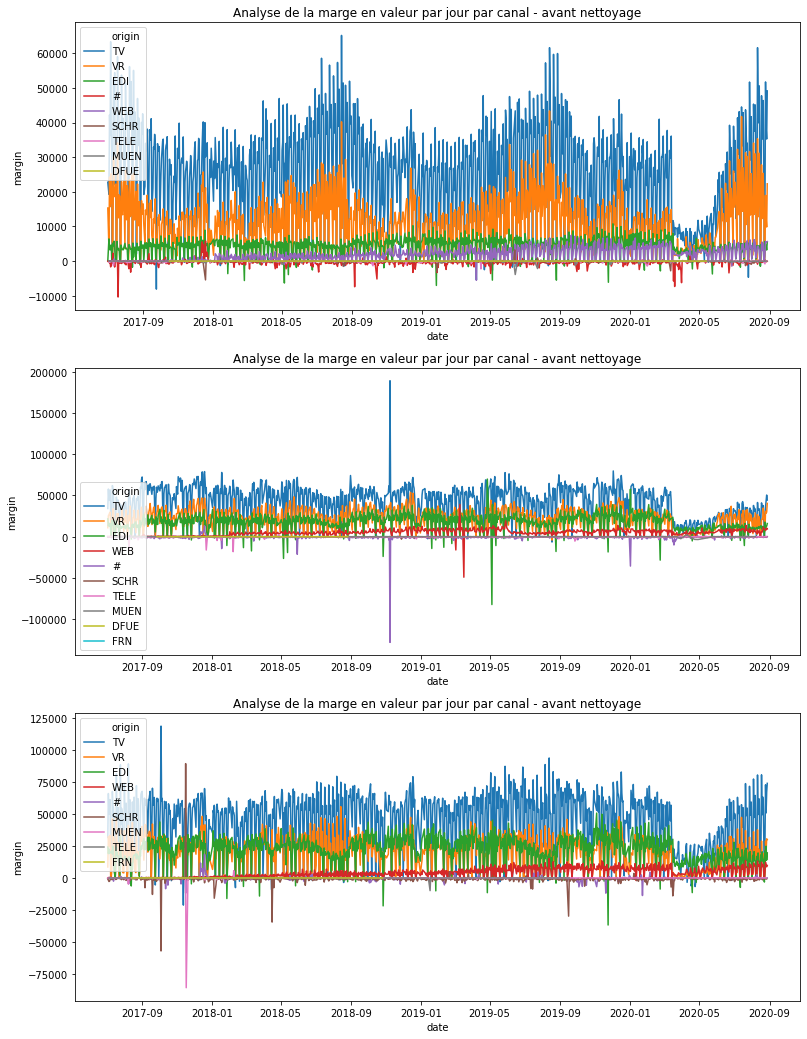

In [14]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1)
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage')


# fig, ax = plt.subplots(figsize=(15, 12))
# data_to_plot = (
# data.loc[data.orgacom == '1ALO']
#     .groupby(['date', 'origin'])['margin']
#     .sum()
#     .unstack('origin')
#     .rolling(1)
#     .mean()
#     .stack('origin')
#     .rename('margin')
#     .reset_index()
# )
# sns.lineplot(data=data_to_plot, x='date', y='margin', hue='origin', ax=ax)
# ax.set_title('Analyse de la marge en valeur par jour par canal - avant nettoyage')
# ax.set_xticklabels([])

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

### Calcul d'une table des avoirs, aggrégée

In [15]:
mask_ZC = data.doctype.isin(['ZC10'])
mask_ZA = data.doctype.isin(['ZA01', 'ZA02'])
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [16]:
grouper_fields = ['orgacom', 'date', 'client', 'material']
raw_avoirs = data.loc[mask_ZA, grouper_fields + ['margin', 'brutrevenue', 'weight']].copy()
avoirs = raw_avoirs.groupby(grouper_fields, observed=True).sum()
avoirs

margin  brutrevenue  weight
orgacom date       client     material                                       
1SOU    2017-07-03 0000069379 000000000000137154    2.39       -27.24  -5.000
                   0000070453 000000000000026211   -1.16        -6.74  -7.500
                   0000137251 000000000000097256  -28.66      -112.22 -15.330
                   0000137369 000000000000095083   -0.20       -14.04  -2.025
                   0000137989 000000000000095042   -0.32       -27.26  -1.152
...                                                  ...          ...     ...
1LRO    2020-08-27 0000229435 000000000000194409    0.01         0.00   0.000
                   0000230601 000000000000191742  -21.80       -34.07  -6.000
                   0000266001 000000000000012986    0.01         0.00   0.000
                              000000000000038670    0.02         0.00   0.000
                   0003002530 000000000000007321  -14.02       -32.79  -5.000

[90149 rows x 3 columns]

On identifie ensuite les lignes de commandes qui ne sont pas dupliquées dans le dataset initial.

In [17]:
mask_dup_ZC = data.loc[mask_ZC].duplicated(grouper_fields, keep=False).rename('_duplicated')
print(f'Number of duplicated lines in orders: {sum(mask_dup_ZC)}')
mask_dup_ZC = mask_dup_ZC.reindex(data.index, fill_value=False)
data = (data.merge(mask_dup_ZC, how='left', left_index=True, right_index=True))

Number of duplicated lines in orders: 545698


On calcule les indicateurs à remplacer : 
  - correspondent à des commandes, dont les lignes ne sont pas dupliquées
  - ne font pas passer les poids ou les CA bruts négatifs

In [18]:
indicators = ['margin', 'weight', 'brutrevenue']
to_update = (
data.loc[~data._duplicated & mask_ZC, grouper_fields + indicators]
    .merge(avoirs, left_on=grouper_fields, right_index=True, validate='1:1')
)
for indicator in indicators:
    to_update[indicator] = to_update[indicator + '_x'] + to_update[indicator + '_y']
to_update = to_update.loc[(to_update.weight >= 0) & (to_update.brutrevenue >= 0)]
to_update.sample(5)

,orgacom,date,client,material,margin_x,weight_x,brutrevenue_x,margin_y,brutrevenue_y,weight_y,margin,weight,brutrevenue
30823547,1SOU,2020-07-01,0000224110,000000000000094946,0.77,9.600,49.92,-0.77,-49.92,-9.600,0.00,0.000,0.00
18188835,1SOU,2019-03-12,0000250767,000000000000183130,0.79,0.909,12.94,0.74,12.13,0.852,1.53,1.761,25.07
27583248,1ALO,2020-01-31,0000020626,000000000000208477,69.98,40.000,155.68,-67.62,-67.62,0.000,2.36,40.000,88.06
3430839,1ALO,2017-10-27,0000152586,000000000000067697,-0.61,0.000,0.00,0.61,0.00,0.000,0.00,0.000,0.00
22528038,1SOU,2019-08-08,0000109229,000000000000203374,1.28,1.440,8.93,-1.28,-8.93,-1.440,0.00,0.000,0.00


On contrôle que les quelques grosses lignes en erreur sont bien corrigées.

In [19]:
to_update.sort_values('margin_x', ascending=False).head(5)

,orgacom,date,client,material,margin_x,weight_x,brutrevenue_x,margin_y,brutrevenue_y,weight_y,margin,weight,brutrevenue
14479286,1ALO,2018-11-08,0000243129,000000000000026893,127569.14,150.000,127650.00,-127522.35,-127522.35,0.000,46.79,150.00,127.65
2859632,1SOU,2017-10-04,0000100449,000000000000026230,57018.93,23652.315,220203.05,-57007.65,-220159.48,-23647.635,11.28,4.68,43.57
26794767,1ALO,2020-01-02,0000027075,000000000000191247,35083.11,10.000,39461.10,-35065.55,-39421.64,0.000,17.56,10.00,39.46
8341004,1SOU,2018-04-16,0000137838,000000000000133005,33849.74,34360.000,178603.28,-33815.89,-178424.68,-34325.640,33.85,34.36,178.60
23854187,1SOU,2019-09-16,0000158986,000000000000082856,27687.64,4.800,28560.00,-27678.76,-28534.80,0.000,8.88,4.80,25.20


In [20]:
to_update.margin_y.sum()

-444364.1

On retire les indicateurs temporaires : 

In [21]:
to_update.drop(columns=['margin_x', 'margin_y', 'weight_x', 'weight_y', 'brutrevenue_x', 'brutrevenue_y'], inplace=True)

Suppression des avoirs :

In [22]:
data = data.loc[(data.merge(to_update, how='left', on=grouper_fields, indicator=True)._merge == 'left_only')
                | ~data.doctype.isin(['ZA01', 'ZA02'])]

Mise à jour des lignes de commande : 

In [23]:
merged = data.merge(to_update, on=grouper_fields, how='left', indicator=True)
del(to_update)

In [24]:
merged_mask_ZC = merged.doctype.isin(['ZC10',])
for indicator in indicators:
    merged.loc[:, indicator + '_z'] = merged[indicator + '_x'].where(merged[indicator + '_y'].isna() | ~merged_mask_ZC,
                                                                    merged[indicator + '_y'])
    
merged['margin_z'].sum()

202191096.81000006

In [25]:
for indicator in indicators:
    merged[indicator] = merged[indicator + '_z']
    merged = merged.drop(columns=[indicator + '_x', indicator + '_y', indicator + '_z'])
merged = merged.drop(columns='_merge')
data = merged
del(merged)

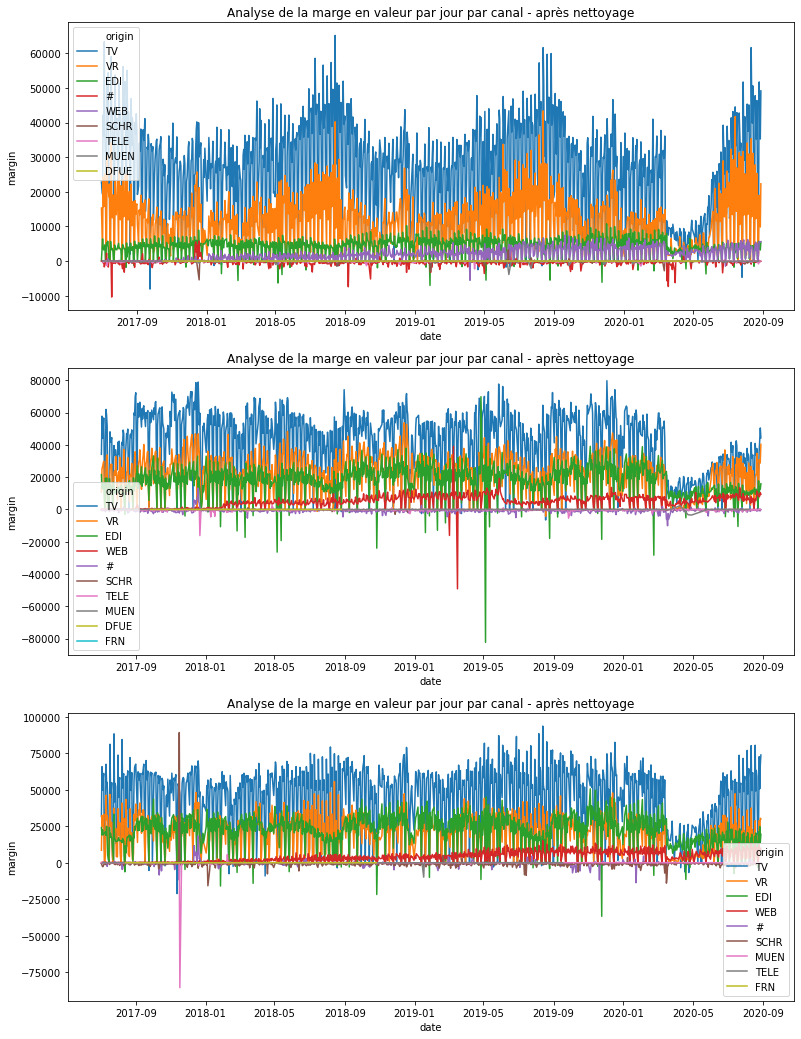

In [26]:
fig, axs = plt.subplots(figsize = (13, 18), nrows=len(data.orgacom.unique()))
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1)
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_, x='date', y='margin', hue='origin', ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage')


## Affichage des indicateurs par succursale et canal

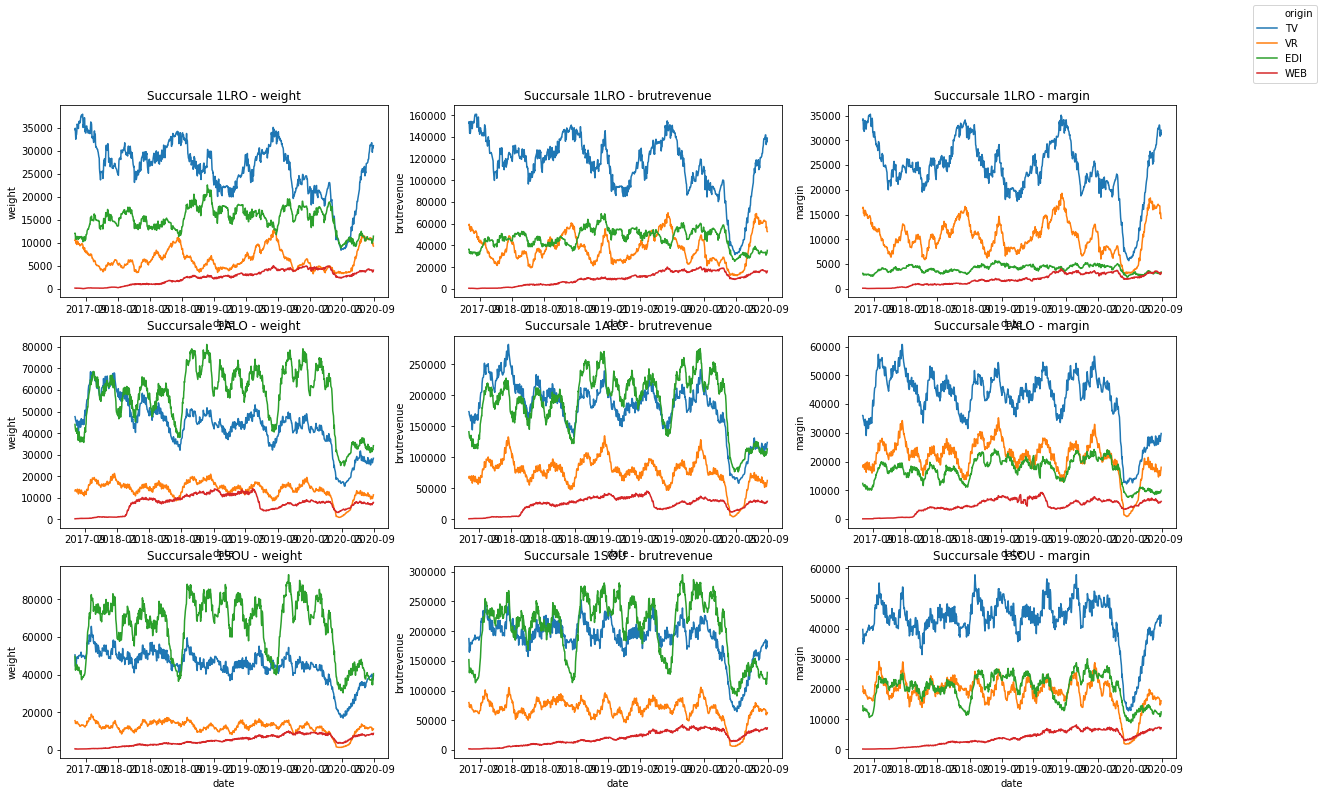

In [27]:
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 20
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)), nrows=len(SV), ncols=len(indicators), squeeze=False)
for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicators):
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot, x='date', y=indicator, hue='origin', ax=axs[i, j])
        axs[i, j].get_legend().remove()
        axs[i, j].set_title(f'Succursale {suc} - {indicator}')
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)


## Affichage indicateurs sur les postes de commande par canal

In [28]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
# origins = ['TV', 'VR', 'WEB', 'EDI']
data['origin2'] = data.origin.astype(origin2_cat)

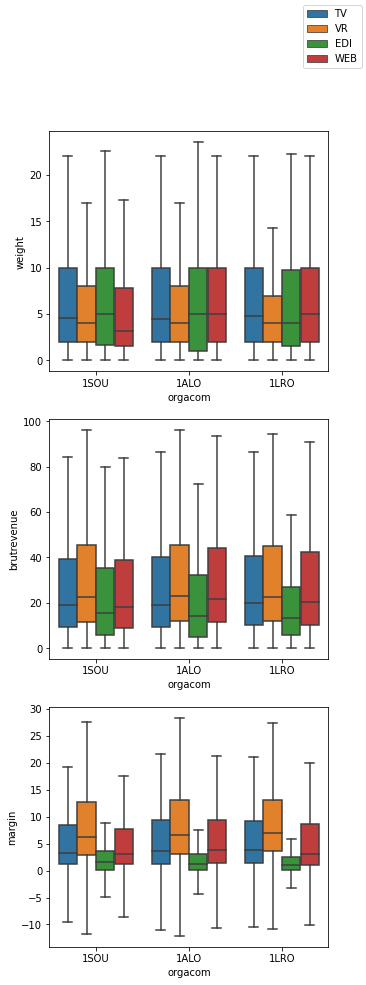

In [29]:
fig, axs = plt.subplots(figsize=(5, 15), nrows=len(indicators), squeeze=False)
data_to_plot = data.loc[data.origin.isin(['WEB', 'TV', 'VR', 'EDI']) &
                        data.doctype.isin(['ZC10'])]
for j, indicator in enumerate(indicators):
    sns.boxplot(data=data_to_plot, y=indicator, x='orgacom', hue='origin2', ax=axs[j, 0], showfliers=False)
    axs[j, 0].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

## Affichage des indicateurs par commande

In [30]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
orders

margin  brutrevenue  weight  linecount
orgacom date       client     origin2                                        
1SOU    2017-07-03 0000065940 TV        31.16        84.01   5.501          9
                   0000065945 TV         6.02        23.69   3.734          2
                   0000065975 TV        25.15        97.40  13.718          1
                   0000065998 TV         4.12         8.56   1.000          1
                   0000066014 TV        17.89        48.30   5.000          1
...                                       ...          ...     ...        ...
1LRO    2020-08-28 0000285485 TV        10.05        30.34   4.045          1
                              VR       106.57       314.40  41.414         13
                   0000285532 VR        97.39       654.05  90.556         12
                   0003004575 VR        16.83        49.75   5.000          1
                   SL0071     TV        13.93       229.58  47.500          2

[2342199 rows x 4 columns]

In [75]:
orders['PMVK'] = orders.brutrevenue / orders.weight
orders['marginperkg'] = orders.brutrevenue / orders.weight
orders['marginpercent'] = orders.margin / orders.brutrevenue
orders['lineweight'] = orders.weight / orders.linecount
orders = orders.reset_index()

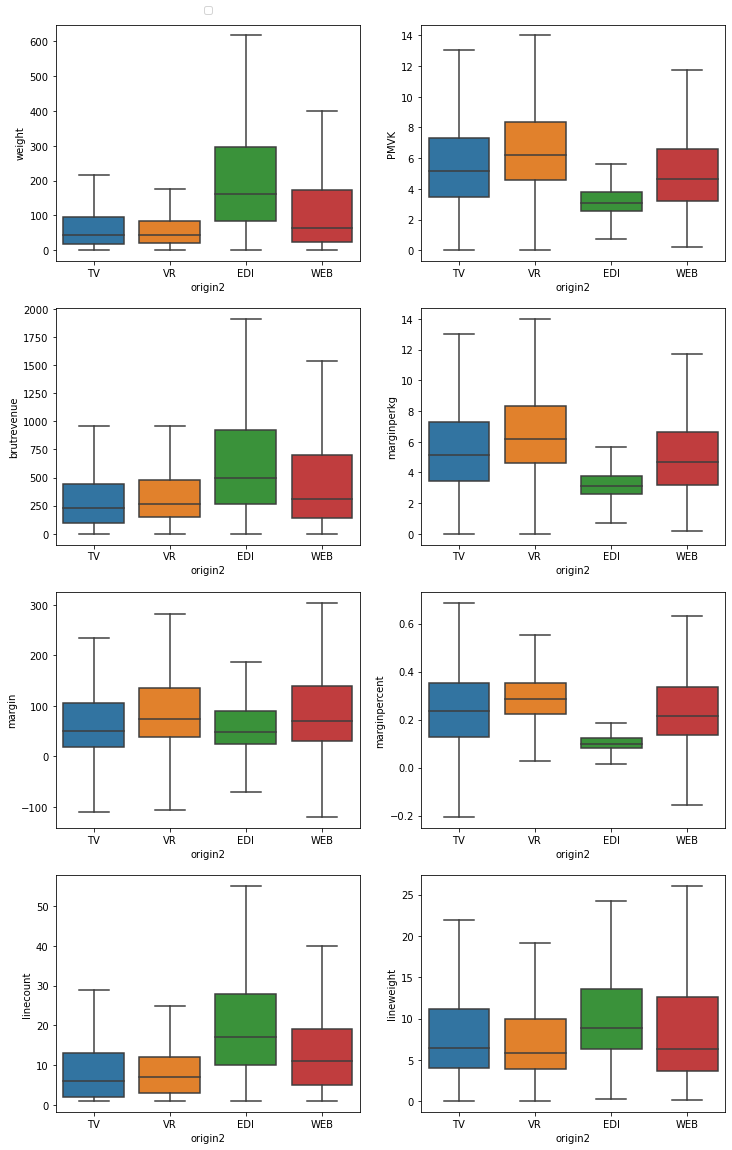

In [106]:
indicators2 = ['weight', 'brutrevenue', 'margin', 'linecount', 'PMVK', 'marginperkg', 'marginpercent', 'lineweight']
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator, x='origin2', hue=None, ax=axs[x, y], showfliers=False)
#     axs[x, y].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [107]:
orders.groupby(['origin2']).mean().loc[:, indicators2]

,weight,brutrevenue,margin,linecount,PMVK,marginperkg,marginpercent,lineweight
origin2,,,,,,,,
TV,89.266615,376.014236,84.851438,9.621277,5.980800,5.980800,0.157112,11.801752
VR,69.206999,387.667731,108.270108,9.368883,7.122948,7.122948,-0.187007,9.833005
EDI,248.534123,794.372413,74.268972,21.089516,3.416330,3.416330,0.102230,12.997135
WEB,161.557616,584.607611,109.605752,13.299835,5.573011,5.573011,0.247325,12.594828


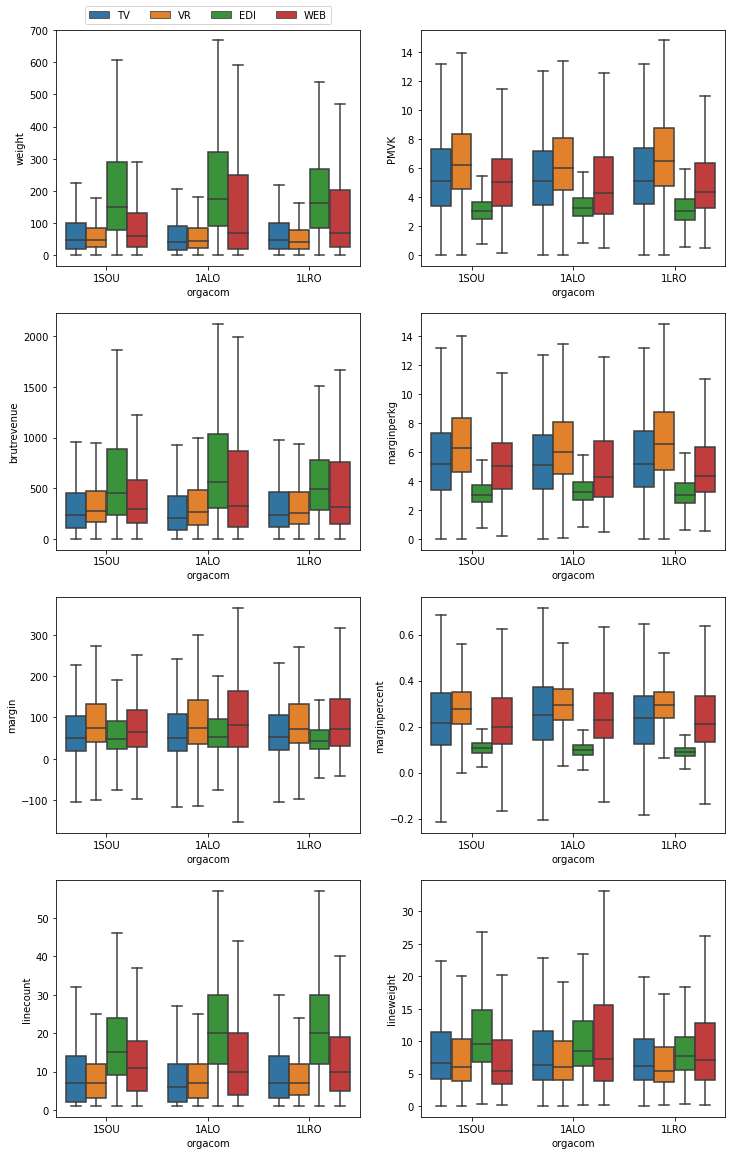

In [98]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders, y=indicator, x='orgacom', hue='origin2', ax=axs[x, y], showfliers=False)
    axs[x, y].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [103]:
orders.groupby(['orgacom', 'origin2']).mean().loc[:, indicators2]

weight  brutrevenue      margin  linecount      PMVK  \
orgacom origin2                                                             
1ALO    TV        89.853114   369.213251   85.662524   9.402013  5.925482   
        VR        72.816435   400.813857  112.248227   9.753133  6.960489   
        EDI      261.264049   859.016743   77.928519  23.220783  3.540977   
        WEB      202.608452   656.955629  125.197220  14.089903  5.520952   
1LRO    TV        92.891947   405.893925   87.043846   9.998615  6.058161   
        VR        64.396033   372.092850  105.390225   9.170430  7.387372   
        EDI      213.671919   659.921270   57.277071  22.367235  3.416715   
        WEB      162.409599   615.468390  117.745126  13.639468  5.359326   
1SOU    TV        86.609855   364.361814   82.842914   9.591560  5.983833   
        VR        68.601035   384.244127  106.088862   9.108393  7.120309   
        EDI      248.706979   782.822426   76.352757  19.042175  3.318288   
        WEB      125.932296   509.259309   92.730729  12.475883  5.709158   

                 marginperkg  marginpercent  lineweight  
orgacom origin2                                          
1ALO    TV          5.925482       0.231625   12.099164  
        VR          6.960489       0.287956    9.546732  
        EDI         3.540977       0.098658   12.603428  
        WEB         5.520952       0.265056   15.185093  
1LRO    TV          6.058161       0.231413   11.371653  
        VR          7.387372       0.280400    8.892778  
        EDI         3.416715       0.090414   11.105487  
        WEB         5.359326       0.243500   11.744822  
1SOU    TV          5.983833       0.047637   11.793808  
        VR          7.120309      -0.954239   10.706821  
        EDI         3.318288       0.108484   13.858516  
        WEB         5.709158       0.233733   10.733609

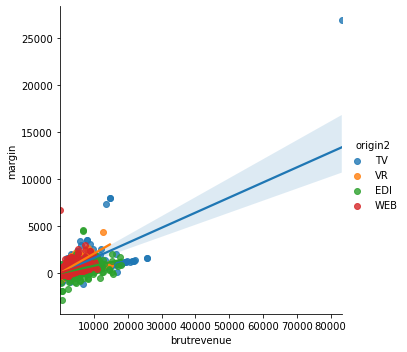

In [108]:
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.regplot(x, y, ax=ax)
samples = [orders.loc[orders.origin2 == origin].sample(100000, replace=True) for origin in orders.origin2.unique()]
samples = pd.concat(samples, axis=0)
samples
sns.lmplot(data=samples, x='brutrevenue', y='margin', hue='origin2')

On ajoute quelques données du dataset client.

In [72]:
clt_fields = ['seg1', 'hier4']
try:
    orders = orders.drop(clt_fields)
except: 
    pass
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')

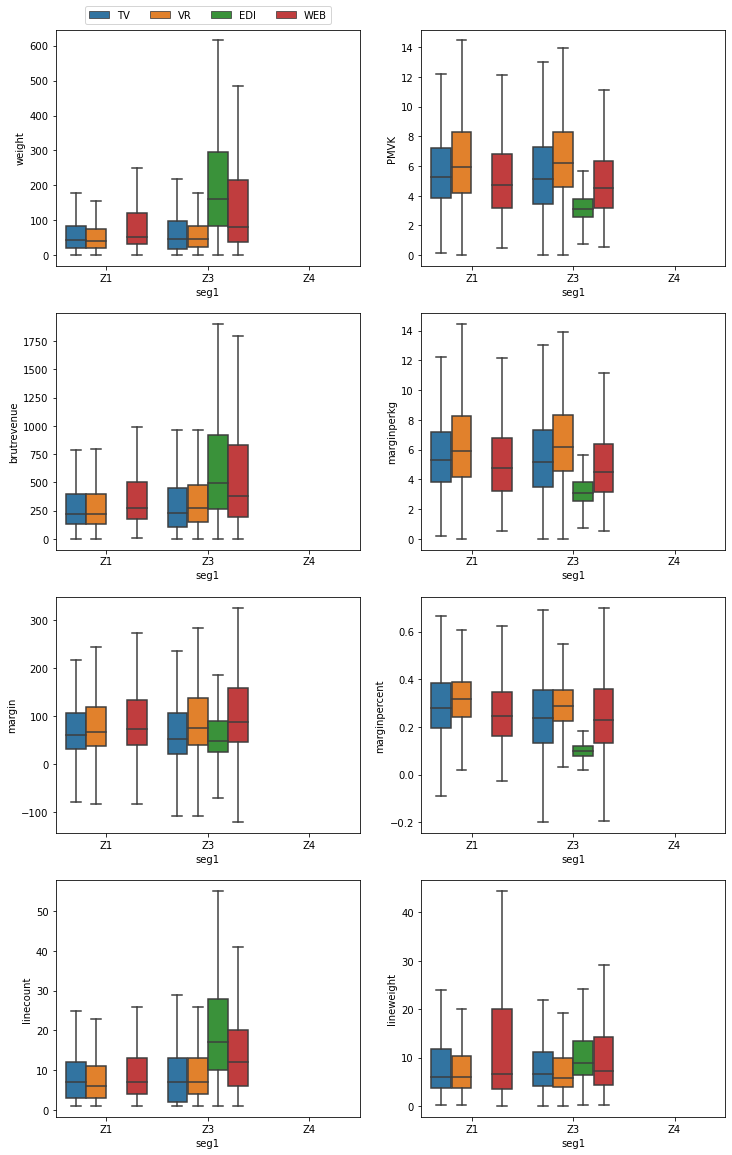

In [99]:
mask_filter = orders.seg1.isin(['Z1', 'Z3'])

fig, axs = plt.subplots(figsize=(12, 20), nrows=len(indicators2) // 2, ncols=2, squeeze=False)
for j, indicator in enumerate(indicators2):
    x, y = j % (len(indicators2) // 2), j // (len(indicators2) // 2)
    sns.boxplot(data=orders.loc[mask_filter], y=indicator, x='seg1', hue='origin2', ax=axs[x, y], showfliers=False)
    axs[x, y].get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

In [111]:
orders.loc[orders.seg1.isin(['Z1', 'Z3']), indicators2 + ['orgacom', 'seg1']].groupby(['orgacom', 'seg1'], observed=True).mean()


weight  brutrevenue     margin  linecount      PMVK  \
orgacom seg1                                                            
1ALO    Z3    128.620632   493.911320  92.263705  12.695915  5.517121   
        Z1     80.327341   304.419174  83.094486   7.779403  6.521482   
1LRO    Z3    107.820236   447.480854  89.083270  12.021637  5.885088   
        Z1     81.144345   368.024017  85.649139   8.703461  6.257172   
1SOU    Z3    129.454530   491.350955  87.274768  12.292921  5.445156   
        Z1     81.904563   364.423156  93.185636   9.435793  6.250946   

              marginperkg  marginpercent  lineweight  
orgacom seg1                                          
1ALO    Z3       5.517121       0.228422   11.587920  
        Z1       6.521482       0.306071   21.229883  
1LRO    Z3       5.885088       0.226596   10.515346  
        Z1       6.257172       0.225052   13.656352  
1SOU    Z3       5.445156      -0.109109   12.117109  
        Z1       6.250946       0.133275   14.174379

## Impact du Web sur les indicateurs, à la marge du client

In [112]:
orders

,index,orgacom,date,client,origin2,margin,brutrevenue,weight,linecount,PMVK,marginperkg,marginpercent,seg1,hier4,lineweight
0,0,1SOU,2017-07-03,0000065940,TV,31.16,84.01,5.501,9,15.271769,15.271769,0.370908,Z3,10897,0.611222
1,45783,1SOU,2017-08-28,0000065940,TV,44.36,105.93,8.048,10,13.162276,13.162276,0.418767,Z3,10897,0.804800
2,57100,1SOU,2017-09-08,0000065940,TV,17.60,40.35,3.000,2,13.450000,13.450000,0.436183,Z3,10897,1.500000
3,63976,1SOU,2017-09-15,0000065940,TV,100.12,236.77,20.312,3,11.656656,11.656656,0.422858,Z3,10897,6.770667
4,72318,1SOU,2017-09-25,0000065940,TV,96.04,253.99,40.338,5,6.296544,6.296544,0.378125,Z3,10897,8.067600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342190,2342190,1LRO,2020-08-28,0000284259,EDI,17.60,134.92,53.300,8,2.531332,2.531332,0.130448,Z3,11059,6.662500
2342191,2342193,1LRO,2020-08-28,0000285463,VR,98.81,393.49,64.964,15,6.057047,6.057047,0.251112,Z3,NaN,4.330933
2342192,2342194,1LRO,2020-08-28,0000285485,TV,10.05,30.34,4.045,1,7.500618,7.500618,0.331246,Z3,NaN,4.045000
2342193,2342195,1LRO,2020-08-28,0000285485,VR,106.57,314.40,41.414,13,7.591636,7.591636,0.338963,Z3,NaN,3.185692


In [137]:
for indicator in indicators2:
    grouped = orders.groupby(['orgacom', 'client'])
    orders[indicator + '_clt_mean'] = grouped[indicator].transform('mean')
    orders[indicator + '_clt_std'] = grouped[indicator].transform('std')
    orders[indicator + '_clt_zscore'] = (orders[indicator] - orders[indicator + '_clt_mean']) / orders[indicator + '_clt_std']
    del(orders[indicator + '_clt_mean'])
    del(orders[indicator + '_clt_std'])
    print(f'{indicator} done!')
print('ALL DONE!')

weight done!
brutrevenue done!
margin done!
linecount done!
PMVK done!
marginperkg done!
marginpercent done!
lineweight done!
ALL DONE!


In [178]:
sum(orders.origin2 == 'WEB') / len(orders.origin2)

0.03789266051716445

0000067290 - CENTRE DE SOINS DE SUITE ET READA


<AxesSubplot:xlabel='brutrevenue_clt_zscore', ylabel='margin_clt_zscore'>

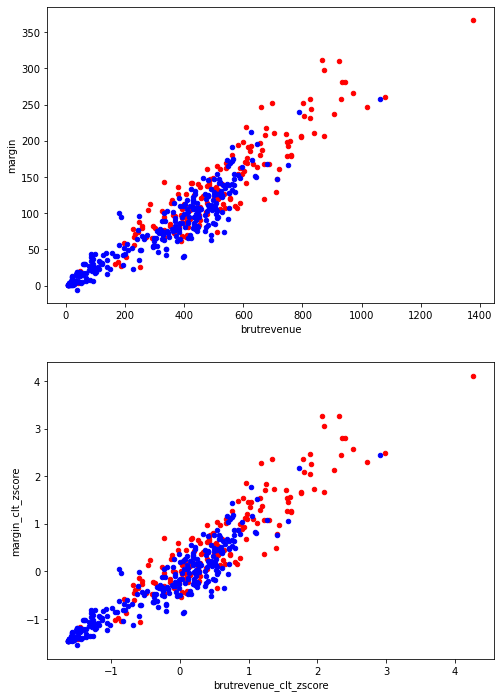

In [184]:
sample = orders.loc[orders.origin2 == 'WEB'].sample(1).iloc[0]
oc, client = sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 12), nrows=2)
mask_web = (orders.client == client) & (orders.origin2 == 'WEB')
mask_other = (orders.client == client) & (orders.origin2 != 'WEB')
orders.loc[mask_web].plot(kind='scatter', y='margin', x='brutrevenue', color='red', ax=axs[0])
orders.loc[mask_other].plot(kind='scatter', y='margin', x='brutrevenue', color='blue', ax=axs[0])
orders.loc[mask_web].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='red', ax=axs[1])
orders.loc[mask_other].plot(kind='scatter', y='margin_clt_zscore', x='brutrevenue_clt_zscore', color='blue', ax=axs[1])


<AxesSubplot:xlabel='brutrevenue_clt_zscore', ylabel='margin_clt_zscore'>

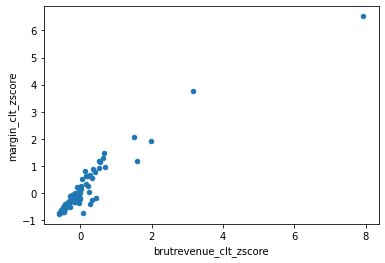

### Identification des outliers

In [ ]:
data.describe()

Après analyse, il apparaît qu'il n'y a pas d'erreur sur les poids.

On va déterminer les zscore pour chacun des 3 indicateurs principaux.

In [ ]:
for indicator in indicators:
    data[indicator + '_zscore'] = data[indicator] - data[indicator].mean() / data[indicator].std(ddof=0)

In [ ]:
for indicator in indicators:
    orders[indicator + '_zscore'] = (orders[indicator] - orders[indicator].mean()) / orders[indicator].std(ddof=0)()

In [ ]:
mask_zscore = (
    (abs(orders['margin_zscore']) < 3.) &
    (abs(orders['brutrevenue_zscore']) < 3.) &
    (abs(orders['weight_zscore']) < 3.)
)
print(f'{sum(mask_zscore) / len(orders):.2%} orders are kept after zscore filtering')

In [ ]:
sns.regplot(data=orders[mask_zscore], x='margin', y='brutrevenue', order=1)

In [ ]:
fig, axs = plt.subplots(figsize=(7, 5 * len(indicators)), nrows=len(indicators))
for i, indicator in enumerate(indicators):
    sns.regplot(data=orders[mask_zscore], x='WEB_percent', y=indicator, order=1, ax=axs[i])
    axs[i].set_title(f'{indicator} en fonction de la proportion de WEB')

In [ ]:
sns.regplot(data=orders[mask_zscore], x='WEB_percent', y='order_line_count', order=1)

In [ ]:
sns.kdeplot(data=orders.loc[mask_zscore, 'WEB_percent'], data2=orders.loc[mask_zscore, 'margin'])

TO BE CONTINUED

# Analyse
## Progression du Web au fil du temps
### En nombre de lignes

In [ ]:
test.loc[test.weight < 0].groupby('doctype').size()

In [ ]:
test = (
raw_data.loc[raw_data.doctype.isin(invalid_doctypes),
             ['date', 'client', 'doctype', 'material', 'origin', 'weight', 'brutrevenue', 'marginperkg']]
)
test['margin'] = test['marginperkg'] * test['weight']
test.groupby(['origin', 'doctype']).size().unstack('origin')

In [ ]:
raw_data.loc[raw_data.doctype.isin(invalid_doctypes), ['weight', 'material', 'client']].describe(include='all')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
data_to_plot = (
    data.loc[:, ['origin', 'date', 'margin']]
        .groupby(['origin', 'date'], observed=True)
        .sum()
        .unstack('origin', fill_value=0)
        .rolling(1)
        .mean()
)
data_to_plot.plot(kind='line', ax=ax)

In [ ]:
data.loc[data.margin == data.margin.max(), ['date', 'material', 'client', 'brutrevenue', 'weight', 'marginperkg', 'margin']]

In [ ]:
avoirs = raw_data.loc[raw_data.doctype.isin(['ZA01', 'ZA02'])]
commandes = raw_data.loc[raw_data.doctype.isin(['ZC10', 'ZC01', 'ZC02'])]

In [ ]:
avoirs.merge(commandes, 
             on=['week', 'client', 'material'],
             how='left',
             indicator=True,
#              validate='1:1',
             ).loc[lambda x: x['_merge'] == 'left_only']

In [ ]:
raw_data.sort_values('margin', ascending=False)[['doctype', 'date', 'origin', 'material', 'client', 'brutrevenue', 'weight', 'marginperkg', 'margin']]

In [ ]:
myfields = ['doctype', 'date', 'origin', 'material', 'client', 'brutrevenue', 'weight', 'marginperkg', 'margin']
(
raw_data.loc[raw_data.doctype == 'ZA03', fields]
#         .loc[raw_data.weight > 0.]
)

In [ ]:
raw_data['margin'] = raw_data.marginperkg * raw_data.weight

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 8))
(
data.groupby(['origin', 'date', 'brutrevenue', 'margin', 'weight'], observed=True)
     .agg('sum')
     .unstack('origin', fill_value=0)
     .rolling(20)
     .mean()
     .plot(kind='line', ax=ax)
)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
(
data.loc[data.origin.isin(['#', 'TV', 'WEB', 'VR'])]
    .pivot_table(aggfunc='size', columns='origin', index='week')
    .plot(kind='bar', stacked=True, legend=False, ax=ax)
)

In [ ]:
plot_data = (
data.loc[data.origin.isin(['#', 'TV', 'WEB', 'VR'])]
    .groupby(['month', 'origin'], observed=True)
    .size()
    .rename('line_count')
    .reset_index()
    .pivot_table(columns='origin')
)
fig, ax = plt.subplots(figsize=(8,5))
# plt.bar(x=plot_data.month, height=plot_data.line_count, )#hue=plot_data.origin)
plot_data.plot(x='month', y='line_count', kind='bar', stacked=True, ax=ax)

In [ ]:
(data.loc[data.doctype.isin(['ZC10', 'ZC01'])]
     .groupby('origin', observed=True)
     .mean())

In [ ]:
orders = (
data.loc[data.doctype.isin(['ZC10']) & (data.weight != 0)]
    .groupby(['date', 'origin', 'client'],
             observed=True,
            )
    .agg ({'brutrevenue': 'sum',
           'weight': 'sum', 
           'margin': 'sum',
           'material': 'count',
          })
    .rename({'material': 'linecount'}, axis=1)
)
orders

In [ ]:
orders['marginperkg'] = orders.margin / orders.weight
orders

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
(
orders.groupby(['origin', 'date'], observed=True)['margin']
      .sum()
      .unstack('origin', fill_value=0)
      .rolling(20)
      .mean()
      .plot(kind='line', ax=ax)
)

In [ ]:
(orders.groupby(['origin', 'date'], observed=True)['margin']
      .sum()
      .idxmax()
)

In [ ]:
(data.loc[data.date == '2018-11-08', ]
     .sort_values(ascending=False, by='margin')
     .head(10)
)

In [ ]:
(
data.loc[data.origin.isin(['VR', 'TV', 'WEB']) & data.doctype.isin(['ZC10'])]
    .groupby(['orgacom_x', 'date', 'client', 'origin'], observed=True)
    .size()
    .reset_index()
    .groupby(['date', 'orgacom_x', 'client'], observed=True)
    .size()
    .loc[lambda x: x>1]
)

In [ ]:
smol_data = data.loc[data.date >= '2019-06-01']
smol_data

In [ ]:
smol_data.loc[smol_data.origin.isin(['TV', 'WEB', 'VR'])]

In [ ]:
order_count = (
smol_data.loc[smol_data.origin.isin(['TV', 'WEB', 'VR']), ['orgacom_x', 'date', 'client', 'origin']]
         .drop_duplicates()
         .groupby(['orgacom_x', 'date', 'client'], observed=True)
         .size()
         .loc[lambda x: x>1]
         .rename('order_count')
)
order_count

In [ ]:
web_orders = (
smol_data.loc[smol_data.origin.isin(['WEB']), ['orgacom_x', 'date', 'client']]
         .drop_duplicates()
)
web_orders

In [ ]:
(smol_data.merge(web_orders.set_index(['orgacom_x', 'date', 'client']),
                on=['orgacom_x', 'date', 'client'],
                how='left', 
                indicator=True
               ).loc[lambda x: x._merge=='both']
                .drop('_merge', axis=1)
                .merge(order_count.reset_index(), 
                       how='left', 
                       on=['orgacom_x', 'date', 'client'],
                       indicator=True)
                .loc[lambda x: x._merge == 'both', ['orgacom_x', 'date', 'client']]
                .drop_duplicates()
)

In [ ]:
smol_data.loc[(smol_data.client == '0000024852') & (smol_data.date == '2019-06-07'), ['material', 'weight'] ]

In [ ]:
temp = (
smol_data.loc[smol_data.origin.isin(['TV', 'WEB', 'VR']), ['orgacom_x', 'date', 'client', 'origin', 'week']]
         .groupby(['orgacom_x', 'date', 'client', 'origin'], observed=True)
         .transform(lambda x: x.size)
         .rename({'week': 'counts'}, axis=1)
         .join(smol_data)[['orgacom_x', 'date', 'client', 'origin']]
         .groupby(['orgacom_x', 'date', 'client'], observed=True)
         .transform(lambda x: x.size)

)
temp

In [ ]:
temp = (
data.loc[data.origin.isin(['TV', 'WEB', 'VR']), ['orgacom_x', 'date', 'client', 'origin']]
    .groupby(['orgacom_x', 'date', 'client', 'origin'], observed=True)
    .transform(lambda x: x.size)
#     .groupby(['orgacom_x', 'date', 'client'], observed=True)
#     .transform(lambda x: x.size)
)
temp

In [ ]:
temp.columns

In [ ]:
data.sort_index()#.loc[data.origin.isin(['TV', 'WEB', 'VR'])]

In [ ]:
temp.loc[lambda x: x]

In [ ]:
temp.name = 'filter'

In [ ]:
(
data.merge(temp, left_index=True, right_index=True).loc[lambda x: x['filter']]
    .loc[data.date >= '01-06-2019']
)

## Données de base article

In [ ]:
matfields = {'code article':'object',
              'libellé article':'category',
              'code gamme':'category',
              'libellé gamme':'category', 
              'MARC-MMSTA':'category',
              'MARC-LVORM':'category',
              'MVKE-LVORM':'category',
              'MVKE-MVSTA':'category',
              'MARA-LVORM':'category',
              'Hiérarchie produit':'object',
              'Type d\'article':'category',
              'Division':'object', 
              'Org. commerciale':'category', 
              'Canal distribution':'category',
              'File d\'achat':'category', 
              'Marque industrielle':'category', 
              'Marque commerciale':'category', 
              'Grpe de marchandises':'category', 
              'Poids net':'float', 
              'Unité de p':'category',
              'V1':'category',
              'V2':'category',
              'V3':'category',
              'LG1':'category',
              'LG2':'category',         
             }

df_mat = pd.read_csv(Path('..') / 'data' / 'Référentiel_ConverteO_1ALO_Art_20191209.csv', 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=matfields,
                     decimal=",")
df_mat.sample(5)

In [ ]:
num_mat_mask = df_mat['code article'].str.isnumeric()
df_mat.loc[num_mat_mask, 'code article'] = df_mat.loc[num_mat_mask, 'code article'].str.zfill(18)
df_mat.set_index('code article', inplace=True, drop=True)
df_mat.sample(5)

In [ ]:
if sum(df_mat.index.duplicated()):
    raise RuntimeError('Something went wrong on the material dataframe! Some indices are duplicated!')

## Données de base client

In [52]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
]
paths = [Path('..') / 'data' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

,client,V,groupecompte,nom,postalcode,seg1,seg2,seg3,seg4,cat,...,grpclt5,agence,condexp,pricetype,relationtype,pilcom,hier4,hier3,hier2,hier1
31314,181780,A,ZCLT,CAFE DU THEATRE,64100,Z3,Z5,ZK,ZG,ZS,...,051,1BAY,ST,T2,NDI,RGL,NaN,NaN,NaN,NaN
18547,103505,A,ZCHN,RESTAURANT FACE PARK,31320,Z3,Z5,ZK,ZG,ZY,...,051,1TOU,ST,T2,NDI,RGL,NaN,NaN,NaN,NaN
21188,266917,A,ZCLT,TRAITEUR ENGEL PASCAL,57905,Z3,Z5,ZK,ZG,ZY,...,051,1MET,ST,T2,NDI,RGL,NaN,NaN,NaN,NaN
6211,61076,A,ZCLT,RESTAURANT ROUGE TOMATE,34300,Z3,Z5,ZK,ZG,ZW,...,051,1NIM,ST,T1,NDI,RGL,NaN,NaN,NaN,NaN
20238,116406,A,ZCHN,API INSTITUTION ST LOUIS DE GONZAGU,66000,Z3,Z4,ZJ,ZF,ZL,...,NaN,1NIM,ST,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 79732
Duplicated clients before cleansing: 4204
Clients count after cleansing : 77630
Duplicated clients after cleansing: 0


In [58]:
df_clt.sample(5)

,,V,groupecompte,nom,postalcode,seg1,seg2,seg3,seg4,cat,sscat,...,grpclt5,agence,condexp,pricetype,relationtype,pilcom,hier4,hier3,hier2,hier1
orgacom,client,,,,,,,,,,,,,,,,,,,,,
1LRO,0000061725,A,ZCLT,MDR LE MARRONNIER,11000,Z3,Z4,ZI,ZD,ZN,Z19,...,051,1NAR,ST,T3,NDI,NTL,10472,10473,10474,10475
1SOU,0000280091,A,ZCLT,VILLAGE LANDAIS ALZHEIMER,40100,Z3,Z4,ZI,ZB,ZM,Z17,...,031,1BAY,ST,T4,NDI,RGL,10897,196484,196491,199227
1LRO,0000011150,A,ZHIE,TERTIO,75008,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1ALO,0000024760,A,ZCLT,LYCEE LEGT JEAN MONNET,67100,Z3,Z4,ZI,ZB,ZL,Z13,...,031,1STR,ST,T2,NDI,RGL,10897,196484,196489,199692
1LRO,0000222120,A,ZCLT,LE FOURNIL D'ALENYA,66200,Z3,Z5,ZK,ZG,ZW,ZT,...,051,1PER,ST,T1,NDI,RGL,99556,99557,99558,99559


In [59]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [60]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD


# Feature engineering et nettoyage
## Fusion des datasets
### Ajout des données articles
On ajoute dans un premier temps les données article.

In [ ]:
data2 = (
data.merge(df_mat, how='left', left_on='material', right_index=True, validate='many_to_one', indicator=True)
)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données article.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some materials are missing in material master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un code article est en double dans les master data article).

In [ ]:
if len(data2) != len(data):
    raise RuntimeError('Looks like there were duplicate material numbers in material master data!')
data = data2
del data2
data.sample(5)

### Ajout des données client
On commence par fusionner les datasets.

In [ ]:
data2 = data.merge(df_clt,
                   how='left',
                   left_on=['orgacom', 'client'],
                   right_index=True,
                   validate='many_to_one',
                   indicator=True)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données client.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some clients are missing in client master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un couple (orgacom x client) est en double dans les master data client).

In [ ]:
if len(data2) != len(data):
    print('Looks like there were duplicate orgacom x client keys in client master data!')
data = data2
del data2
data.sample(5)